In [10]:
import sklearn.datasets
import itertools
import numpy as np
import pdb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from copy import deepcopy
from sklearn.utils import shuffle
from random import randint
%matplotlib inline

NMAX = 999999999

In [11]:

def get_data():
    dataset = sklearn.datasets.load_diabetes()
    _dataset_X = dataset['data']
    _dataset_y = dataset['target']
    X = np.array(_dataset_X)
    y = np.array(_dataset_y)
    X = np.insert(X, 0, 1, axis=1)
    return [X, y]

def split_train_test(X, y):
    datasize = X.shape[0]
    X, y= shuffle(X, y, random_state = randint(0, 100))
    train_X = X[:int(datasize*80/100)]
    train_y = y[:int(datasize*80/100)]
    test_X = X[int(datasize*80/100):]
    test_y = y[int(datasize*80/100):]
    return [train_X, train_y, test_X, test_y]


In [12]:

def get_beta (X, y, alpha):
    u = np.identity(X.shape[1])*alpha
    beta = np.dot(np.dot(np.linalg.inv(np.add(np.dot(X.T,X),u)), X.T), y)
    return beta
    
def get_rss (X, y, beta):
    loss = np.dot((np.dot(X,beta)-y).T,np.dot(X,beta)-y)
    return loss

In [13]:
def get_subset_X (X, subset):
    new_X = np.array([[1 for k in range(0,X.shape[0])]]).T
    for i in subset[1:]:
        f = []
        if isinstance(i, list):
            f = np.array([[X[k][i[0]]*X[k][i[1]] for k in range(0,X.shape[0])]]).T
        else:
            f = np.array([[X[k][i] for k in range(0,X.shape[0])]]).T
        new_X = np.concatenate((new_X,f),axis=1)
    return new_X

In [14]:

def greedy_subset (X, y, test_X, test_y, alpha):
    no_features = X.shape[1]
    subset = [0]
#     p1 = []
#     p2 = []

    optimal_mse = NMAX
    optimal_beta = []
    optimal_subset = []
    optimal_mse_test = NMAX
    
    for i in range (1, no_features):
        best_rss = NMAX
        best_subset = []
        best_beta = []

        for x in range (0,no_features-3):
                if x not in subset:
                    # print (e)
                    new_subset = subset+[x]
                    new_X = get_subset_X(X,new_subset)

                    new_beta = get_beta(new_X, y, alpha)
                    new_rss = get_rss(new_X, y, new_beta)

                    if best_rss > new_rss:
                        best_rss = new_rss
                        best_beta = new_beta
                        best_subset = new_subset

        for xi in range (1,no_features):
            for yi in range (xi+1,no_features):
                if [xi,yi] not in subset:
                    # print ([xi,yi])
                    new_subset = subset+[[xi,yi]]
                    new_X = get_subset_X(X,new_subset)

                    new_beta = get_beta(new_X, y, alpha)
                    new_rss = get_rss(new_X, y, new_beta)

                    if best_rss > new_rss:
                        best_rss = new_rss
                        best_beta = new_beta
                        best_subset = new_subset
            
            best_mse = best_rss/X.shape[0]
            
            if (optimal_mse*80/100) > best_mse: # if 20% improvement
                optimal_mse = best_mse
                optimal_beta = best_beta
                optimal_subset = best_subset
                optimal_mse_test = get_rss(get_subset_X(test_X,optimal_subset),test_y,optimal_beta)/test_X.shape[0]
                
        subset = best_subset

#         p1.append(best_rss/X.shape[0])
#         p2.append(get_rss(get_subset_X(test_X,best_subset),test_y,best_beta)/test_X.shape[0])

    return [optimal_mse, optimal_mse_test, optimal_beta]


In [15]:

def run_alpha (X, y, test_X, test_y):
    no_runs = 4
    p0 = []
    p1 = []
    p2 = []
    p3 = []
    
    for _alpha in range (0,no_runs):
        alpha = _alpha/10
        _p1, _p2, beta = greedy_subset(X, y, test_X, test_y, alpha)
        p0.append(alpha)
        p1.append(_p1)
        p2.append(_p2)
        p3.append(beta)
    return [p0, p1, p2, p3]

In [16]:
def run():
    dataset_X, dataset_y = get_data()
    p1_avg = np.array([])
    p2_avg = np.array([])
    
    train_X, train_y, test_X, test_y = split_train_test(dataset_X,dataset_y)
    p0, p1, p2, p3 = run_alpha(train_X, train_y, test_X, test_y)
    
    plt.title("Alpha Subset")
    plt.xlabel("alphas")
    plt.ylabel("RSS")
    plt.legend(handles=[mpatches.Patch(color='red', label='train'), mpatches.Patch(color='blue', label='test')])
    plt.plot(p0, p1, marker='o', color='red', linestyle='-')
    plt.plot(p0, p2, marker='o', color='blue', linestyle='-')
    plt.show()

    plt.title("Betas")
    plt.xlabel("alphas")
    plt.ylabel("betas")
    plt.legend(handles=[mpatches.Patch(color='red', label='train'), mpatches.Patch(color='blue', label='test')])
    for i in range(0,len(p0)):
        plt.plot([p0[i] for _ in range(0,len(p3[i]))], p3[i], marker='o', color='red', linestyle='-')
    plt.show()


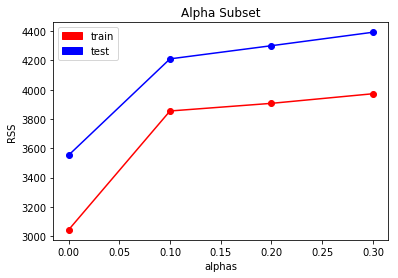

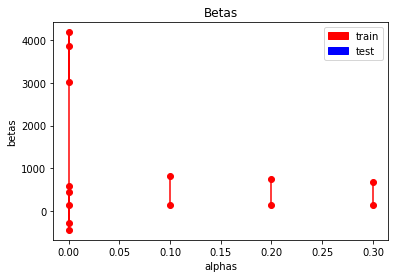

In [20]:
run()
